Tempo gasto atual 5.89012 segundos
cup -  0.9998


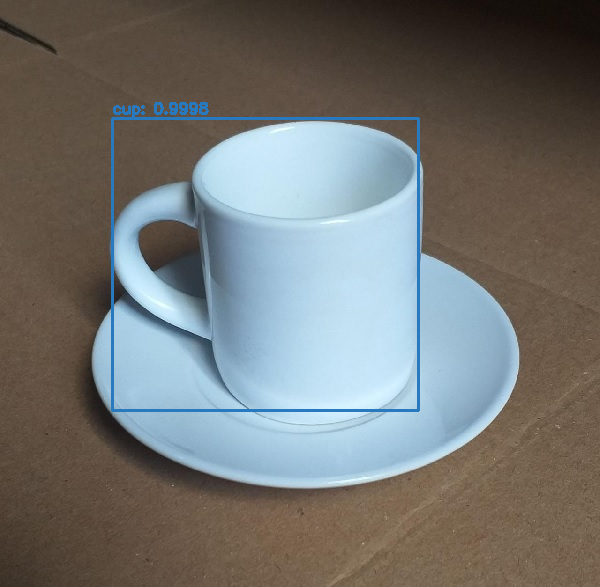

In [1]:
# Detectando Objetos em imagem com OpenCV deep learning library

# Importação das Bibliotecas
import numpy as np
import cv2
import time
#from realsense_depth import *

# Necessário para criar o arquivo contendo os objectos detectados
from csv import DictWriter

from google.colab.patches import cv2_imshow

# Definindo o caminho da imagem
image_path = 'xicara.png'

# Carregando a imagem
frame = cv2.imread(image_path)

# Cria variáveis para captura de altura e largura
h, w = None, None

# Carrega o arquivos com o nome dos objetos que o arquivo foi treinado para detectar
with open('/content/drive/MyDrive/Colab Notebooks/workshop - Elas por Elas (2023)/yolo/yoloDados/YoloNames.names') as f:
    # cria uma lista com todos os nomes
    labels = [line.strip() for line in f]

# carrega os arquivos treinados pelo framework
network = cv2.dnn.readNetFromDarknet('/content/drive/MyDrive/Colab Notebooks/workshop - Elas por Elas (2023)/yolo/yoloDados/yolov3.cfg',
                                     '/content/drive/MyDrive/Colab Notebooks/workshop - Elas por Elas (2023)/yolo/yoloDados/yolov3.weights')

# captura um lista com todos os nomes de objetos treinados pelo framework
layers_names_all = network.getLayerNames()

# Obtendo apenas nomes de camadas de saída que precisamos do algoritmo YOLOv3
# com função que retorna índices de camadas com saídas desconectadas
layers_names_output = \
    [layers_names_all[i - 1] for i in network.getUnconnectedOutLayers()]

# Definir probabilidade mínima para eliminar previsões fracas
probability_minimum = 0.5

# Definir limite para filtrar caixas delimitadoras fracas
# com supressão não máxima
threshold = 0.3

# Gera cores aleatórias nas caixas de cada objeto detectados
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Loop de detecção dos objetos

with open('teste.csv', 'w') as arquivo:
    cabecalho = ['Detectado', 'Acuracia']
    escritor_csv = DictWriter(arquivo, fieldnames=cabecalho)
    escritor_csv.writeheader()
    
    if w is None or h is None:
       h, w = frame.shape[:2]

    # A forma resultante possui número de quadros, número de canais, largura e altura
    # E.G.:
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
                                 swapRB=True, crop=False)

    # Implementando o passe direto com nosso blob e somente através das camadas de saída
    # Cálculo ao mesmo tempo, tempo necessário para o encaminhamento
    network.setInput(blob)  # definindo blob como entrada para a rede
    start = time.time()
    output_from_network = network.forward(layers_names_output)
    end = time.time()

    # Mostrando tempo gasto para um único quadro atual
    print('Tempo gasto atual {:.5f} segundos'.format(end - start))

    # Preparando
    bounding_boxes = []
    confidences = []
    class_numbers = []

    for result in output_from_network:
        for detected_objects in result:
            scores = detected_objects[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            # Eliminando previsões fracas com probabilidade mínima
            if confidence_current > probability_minimum:
                box_current = detected_objects[0:4] * np.array([w, h, w, h])
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                # Adicionando resultados em listas preparadas
                bounding_boxes.append([x_min, y_min,int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)

    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences,
                                probability_minimum, threshold)

        # Verificando se existe pelo menos um objeto detectado

    if len(results) > 0:
        for i in results.flatten():
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            colour_box_current = colours[class_numbers[i]].tolist()
            cv2.rectangle(frame, (x_min, y_min),
                          (x_min + box_width, y_min + box_height),
                          colour_box_current, 2)

            # Preparando texto com rótulo e acuracia para o objeto detectado
            text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])],
                                                    confidences[i])

            # Coloca o texto nos objetos detectados
            cv2.putText(frame, text_box_current, (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour_box_current, 2)

            escritor_csv.writerow({"Detectado": text_box_current.split(':')[0], "Acuracia": text_box_current.split(':')[1]})

            print(text_box_current.split(':')[0] + " - " + text_box_current.split(':')[1])

            cv2_imshow(frame)